In [3]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os.path

In [8]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def lineseg_dist(p, a, b): 
    n_p = p.shape[0] 
    n_s = a.shape[0]

    p_s = np.tile(p, (n_s,1))
    a_s = np.tile(a, (1,n_p)).reshape((-1,2))
    b_s = np.tile(b, (1,n_p)).reshape((-1,2))
    
    dists = lineseg_dists(p_s, a_s, b_s)
    dists = dists.reshape((-1, n_p)).reshape((-1, n_p))
    dists = np.min(dists, axis=0)
    
    return dists


# Generate structured mesh for $x_2$, $x_3$, $h$

Let define $h_c = 20$ and $x_1 = 40$

1. Initial mesh is from $(\frac{x_1 + x_3}{2}, x_3, h)$


2. Deform the mesh from $(\frac{x_1 + x_3}{2}, x_3, h)$ to $(x_2, x_3, h)$
    $$(x, y) \rightarrow (x + \Delta x, y)$$
    
* For the points $x \in [0, \frac{x_1 + x_3}{2}] \qquad y \in [0, h]$ 
    
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{x - 0}{\frac{x_1  + x_3}{2}\frac{y}{h} + (1 - \frac{y}{h})x_1}  \frac{y}{h} \Delta x_{max} $$
       
* For the points $x \in [0, \frac{x_1 + x_3}{2}] \qquad y \in [h, L_y - h]$ 
       
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{x - 0}{\frac{x_1  + x_3}{2}}   \Delta x_{max} $$


* For the points $x \in [0, \frac{x_1 + x_3}{2}] \qquad y \in [L_y - h, L_y]$ 
       
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{x - 0}{\frac{x_1  + x_3}{2}\frac{L_y - y}{h} + (1 - \frac{L_y - y}{h})x_1}  \frac{L_y - y}{h} \Delta x_{max} $$
       
* For the points $x \in [\frac{x_1 + x_3}{2}, L_x] \qquad y \in [0, h]$ 
    
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{L_x - x}{(L_x - \frac{x_1  + x_3}{2})\frac{y}{h} + (1 - \frac{y}{h})(L_x - x_3)}  \frac{y}{h} \Delta x_{max} $$
       
* For the points $x \in [\frac{x_1 + x_3}{2}, L_x] \qquad y \in [h, L_y - h]$ 
       
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{L_x - x}{(L_x - \frac{x_1  + x_3}{2})}  \Delta x_{max} $$


* For the points $x \in [\frac{x_1 + x_3}{2}, L_x] \qquad y \in [L_y - h, L_y]$ 
       
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{L_x - x}{(L_x - \frac{x_1  + x_3}{2})\frac{L_y - y}{h} + (1 - \frac{L_y - y}{h})(L_x - x_3)}  \frac{L_y - y}{h} \Delta x_{max} $$
    
    
Overall, the formula can be written as 

$$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{dx}{(dx_1)dy + (1 - dy)(dx_2)}  dy \Delta x_{max} $$
        
```
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
```

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Step 1
# uniform in y direction


x1, x2, x3, h = 40, 10, 50, 5

def catheter_mesh(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4, plot_or_not = False):

    bottom_x, bottom_y = np.array([0-100, 40.0-100, x2-100, x3-100, 0, 40.0, x2, x3, 100.0]),  np.array([0, 0.0, h, 0, 0.0, 0, h, 0, 0.0])

    # ncy = 20
    
    Ly = 20
    yy = np.linspace(0, Ly, ncy+1)

    Lx = 100
    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    xx = np.hstack((np.linspace(0, x1, ncx1,endpoint=False), np.linspace(x1, (x1+x3)/2, ncx2,endpoint=False), 
                     np.linspace((x1+x3)/2, x3, ncx3,endpoint=False), np.linspace(x3, Lx, ncx4+1)))

    # Step 1

    X, Y = np.meshgrid(xx, yy)

    for i in range(ncx1, ncx1+ncx2+1):
        x = X[0, i]
        Y[:, i] = Y[:, 0]*(Ly - 2*(x - x1)/((x1+x3)/2 - x1)*h)/Ly + (x - x1)/((x1+x3)/2 - x1)*h

    for i in range(ncx1+ncx2, ncx1+ncx2+ncx3+1):
        x = X[0, i]
        Y[:, i] = Y[:, 0]*(Ly - 2*(x3 - x)/(x3 - (x1+x3)/2)*h)/Ly + (x3 - x)/(x3 - (x1+x3)/2)*h
    
    if plot_or_not:
        plt.figure()
        plt.pcolor(X, Y, np.zeros(X.shape), facecolor="none", edgecolors="r")



    # Step 2

    dx1 = np.zeros((ncy+1, ncx+1))
    dx2 = np.zeros((ncy+1, ncx+1))
    dx = np.zeros((ncy+1, ncx+1))
    dy = np.ones((ncy+1, ncx+1)) 
    dx1[:, 0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[:, 0:ncx1+ncx2+1] = x1
    dx1[:, ncx1+ncx2:] = Lx-(x1+x3)/2
    dx2[:, ncx1+ncx2:] = Lx-x3

    dx[:, 0:ncx1+ncx2+1] = X[:, 0:ncx1+ncx2+1]
    dx[:, ncx1+ncx2:] = Lx - X[:, ncx1+ncx2:]

    dy[Y <= h] = Y[Y <= h]/h
    dy[Y >= Ly - h] = (Ly - Y[Y >= Ly - h])/h

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*dy + (1 - dy)*dx2) * dy * Delta_x_max
    X += Delta_x
    
    if plot_or_not:
        plt.figure()
        plt.pcolor(X, Y, np.zeros(X.shape), facecolor="none", edgecolors="r")

        plt.figure()
        plt.scatter(X.flatten(), Y.flatten(), s=0.1)
        plt.plot(bottom_x, bottom_y, color="r")
        
    return X, Y

(array([[  0.        ,   2.        ,   4.        , ...,  95.        ,
          97.5       , 100.        ],
        [  0.        ,   1.65853659,   3.31707317, ...,  94.31372549,
          97.15686275, 100.        ],
        [  0.        ,   1.33333333,   2.66666667, ...,  93.65384615,
          96.82692308, 100.        ],
        ...,
        [  0.        ,   1.33333333,   2.66666667, ...,  93.65384615,
          96.82692308, 100.        ],
        [  0.        ,   1.65853659,   3.31707317, ...,  94.31372549,
          97.15686275, 100.        ],
        [  0.        ,   2.        ,   4.        , ...,  95.        ,
          97.5       , 100.        ]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [18., 18., 18., ..., 18., 18., 18.],
        [19., 19., 19., ..., 19., 19., 19.],
        [20., 20., 20., ..., 20., 20., 20.]]))

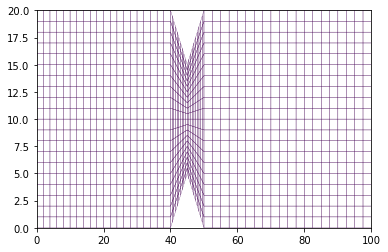

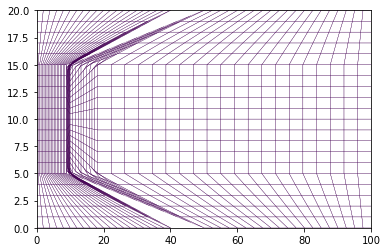

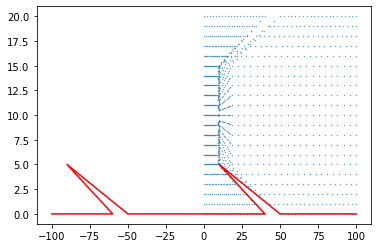

In [6]:
x1, x2, x3, h = 40, 10, 50, 5
ncy = 20
ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20

catheter_mesh(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4, plot_or_not = True)

In [12]:
ncy = 100
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
ncx = ncx1 + ncx2 + ncx3 + ncx4


ndata = len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5))
x_mesh, y_mesh = np.zeros((ncy+1, 2*ncx+1, ndata)), np.zeros((ncy+1, 2*ncx+1, ndata))
wdist_structured_mesh = np.zeros((ncy+1, 2*ncx+1, ndata))


pref_folder = "/groups/esm/dzhuang/Catheter/"
ind = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            
            
            X, Y = catheter_mesh(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
            x_mesh[:, 0:ncx+1, ind], y_mesh[:, 0:ncx+1, ind] = X-100, Y
            x_mesh[:, ncx:, ind], y_mesh[:, ncx:, ind]   = X, Y
            
            
            path = np.vstack(([0, 40.0, x2, x3, 100.0], [0, 0.0, h, 0, 0.0])).transpose()
            path_a, path_b = path[0:-1,:], path[1:,:]
            path = np.vstack(([0.0, 40.0, x2, x3, 100.0], [20.0, 20.0, 20.0-h, 20.0, 20.0])).transpose()
            path_a, path_b = np.vstack((path_a,path[0:-1,:])), np.vstack((path_b,path[1:,:]))
            wdist_1d = lineseg_dist(np.vstack((X.flatten(), Y.flatten())).transpose(), path_a, path_b)
            wdist_structured_mesh[:, 0:ncx+1, ind] = np.reshape(wdist_1d, X.shape)
            wdist_structured_mesh[:, ncx:, ind] = np.reshape(wdist_1d, X.shape)
            
            
            ind += 1
            
np.save(pref_folder+"x_2d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"y_2d_structured_mesh.npy",   y_mesh)
np.save(pref_folder+"wdist_structured_mesh.npy", wdist_structured_mesh)


In [15]:
pref_folder = "/groups/esm/dzhuang/Catheter/"

density_1d_data       = np.load(pref_folder+"density_1d_data.npy")
density_1d_raw_data   = np.load(pref_folder+"density_1d_raw_data.npy")

x_2d_structured_mesh  = np.load(pref_folder+"x_2d_structured_mesh.npy")
y_2d_structured_mesh  = np.load(pref_folder+"y_2d_structured_mesh.npy")
wdist_structured_mesh = np.load(pref_folder+"wdist_structured_mesh.npy")
info_1d_data = np.load(pref_folder+"info_1d_data.npy")

41.0 45.0 2.5


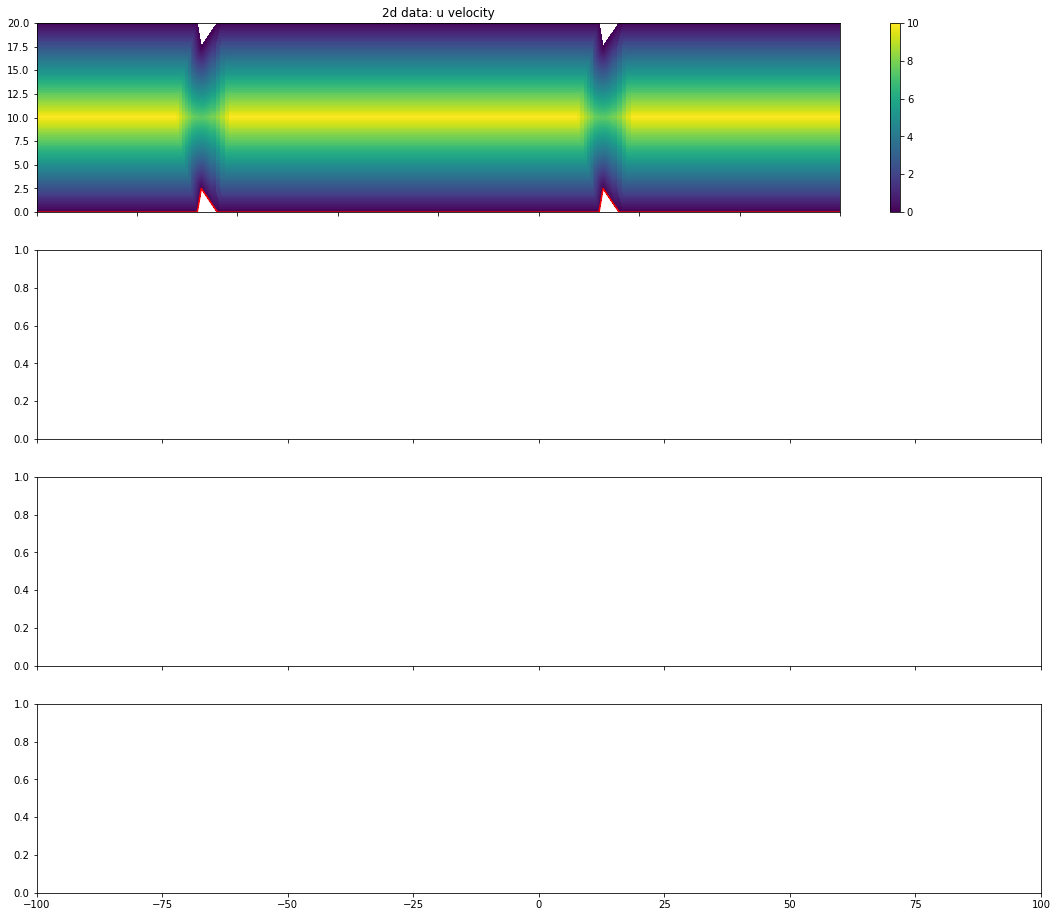

In [16]:
sample_id = 21
fig, ax = plt.subplots(nrows=4,sharex=True, sharey=False, figsize=(18,16))

x2, x3, h, theta1, theta2, p, n_active_1d = info_1d_data[:, sample_id]

print(x2, x3, h)

n_active_1d = np.int64(n_active_1d)
x_2d = x_2d_structured_mesh[:,:,sample_id]
y_2d = y_2d_structured_mesh[:,:,sample_id]
wdist_2d = wdist_structured_mesh[:,:,sample_id]    
density = density_1d_data[:, sample_id]
density_raw = density_1d_raw_data[:, sample_id]

bottom_x, bottom_y = np.array([0-100, 40.0-100, x2-100, x3-100, 0, 40.0, x2, x3, 100.0]),  np.array([0, 0.0, h, 0, 0.0, 0, h, 0, 0.0])

# visualize 2d flow u velocity
im0 = ax[0].pcolormesh(x_2d, y_2d, wdist_2d)
ax[0].plot(bottom_x, bottom_y, color="r")
ax[0].set_title("2d data: u velocity")
fig.colorbar(im0,ax=ax[0])


# # visualize 2d flow wall distance
# im1 = ax[1].pcolormesh(x_2d, y_2d, wdist_2d)
# ax[1].plot(bottom_x, bottom_y, color="r")
# ax[1].set_title("2d data: wall distance")
# fig.colorbar(im1,ax=ax[1])

# # visualize 1d flow u velocity
# x_1d = x_1d_data[:,sample_id][0:n_active_1d]
# y_1d = y_1d_data[:,sample_id][0:n_active_1d]
# u_1d = u_1d_data[:,sample_id][0:n_active_1d]
# wdist_1d = wdist_1d_data[:,sample_id][0:n_active_1d]
# im2 = ax[2].scatter(x_1d, y_1d, s=1, c=wdist_1d)
# ax[2].plot(bottom_x, bottom_y, color="r")
# ax[2].set_title("1d data: wall distance")
# fig.colorbar(im2,ax=ax[2])


# # visualize bacteria density
# im3 = ax[3].pcolormesh(x_2d, y_2d, u_2d, alpha=0.1)
# ax[3].plot(bottom_x, bottom_y, color="r")   
# xx = np.linspace(-100, 100, 2001)
# ax[3].plot(xx, density_raw)
# ax[3].plot(xx, density)

# ax[3].set_title("1d data: bacteria density")
# fig.colorbar(im3,ax=ax[3])

# fig.savefig("Data_vis.png")